In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import TensorFlow modules (edit this list if needed)
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.applications import VGG16

2024-01-10 13:48:56.016015: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 13:48:56.016063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 13:48:56.031535: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 13:48:56.068723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 13:48:57.013155: W tensorflow/compiler/tf2

TensorFlow version: 2.15.0


## Data processing

In [3]:
# Downloading our example data, a .zip of 2000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate --no-clobber \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directories with training/validation cat/dogs pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

# Display the sizes of our dataset
print(f'Number of train cat images: {len(os.listdir(train_cats_dir))}')
print(f'Number of train dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Number of valid cat images: {len(os.listdir(valid_cats_dir))}')
print(f'Number of valid dog images: {len(os.listdir(valid_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
print(train_dog_fnames[:10])

Fichier ‘/tmp/cats_and_dogs_filtered.zip’ déjà présent ; pas de récupération.
Number of train cat images: 1000
Number of train dog images: 1000
Number of valid cat images: 500
Number of valid dog images: 500
['cat.356.jpg', 'cat.853.jpg', 'cat.5.jpg', 'cat.42.jpg', 'cat.341.jpg', 'cat.987.jpg', 'cat.122.jpg', 'cat.626.jpg', 'cat.616.jpg', 'cat.403.jpg']
['dog.615.jpg', 'dog.970.jpg', 'dog.516.jpg', 'dog.785.jpg', 'dog.235.jpg', 'dog.340.jpg', 'dog.563.jpg', 'dog.934.jpg', 'dog.526.jpg', 'dog.672.jpg']


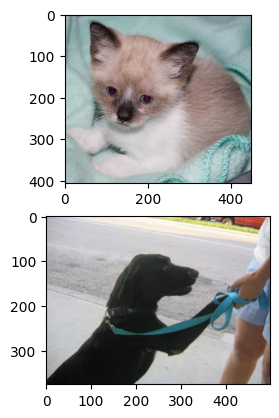

In [4]:
from PIL import Image

img = np.asarray(Image.open(os.path.join(train_cats_dir,train_cat_fnames[0])))
plt.figure(1)
plt.subplot(211)
plt.imshow(img)

img = np.asarray(Image.open(os.path.join(train_dogs_dir,train_dog_fnames[0])))
plt.subplot(212)
plt.imshow(img)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            seed=42,
                                                            batch_size=16,
                                                          label_mode='binary',
                                                          image_size=(128, 128))

valid_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                            shuffle=True,
                                                            seed=42,
                                                            batch_size=16,
                                                          label_mode='binary',
                                                          image_size=(128, 128))

Found 2000 files belonging to 2 classes.


2024-01-10 13:48:59.158558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-10 13:48:59.238265: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-10 13:48:59.238397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 1000 files belonging to 2 classes.


## Training

In [6]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""
    loss = history.history['loss']
    acc = history.history['accuracy']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

    plt.tight_layout()

In [7]:
from keras.applications import vgg16
modelVGG = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(128,128,3))

for layer in modelVGG.layers:
    layer.trainable = False
modelVGG.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [8]:
entireModel = Sequential()
entireModel.add(modelVGG)
entireModel.add(Flatten())
entireModel.add(Dense(128, activation='relu'))
entireModel.add(Dense(32, activation='relu'))
entireModel.add(Dense(16, activation='relu'))
entireModel.add(Dense(8, activation='relu'))
entireModel.add(Dense(1, activation='sigmoid'))

entireModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9

Epoch 1/5


2024-01-10 13:49:01.457526: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-10 13:49:01.618698: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-10 13:49:02.530198: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f74c847ff90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-10 13:49:02.530217: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-01-10 13:49:02.537713: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704890942.611980    8326 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - 7s 34ms/step - loss: 0.6337 - accuracy: 0.7420 - val_loss: 0.3201 - val_accuracy: 0.8590
Epoch 2/5
125/125 [==============================] - 4s 28ms/step - loss: 0.2002 - accuracy: 0.9130 - val_loss: 0.2876 - val_accuracy: 0.8800
Epoch 3/5
125/125 [==============================] - 4s 28ms/step - loss: 0.0912 - accuracy: 0.9625 - val_loss: 0.2776 - val_accuracy: 0.9280
Epoch 4/5
125/125 [==============================] - 3s 28ms/step - loss: 0.0591 - accuracy: 0.9780 - val_loss: 0.2801 - val_accuracy: 0.9200
Epoch 5/5
125/125 [==============================] - 3s 28ms/step - loss: 0.0400 - accuracy: 0.9875 - val_loss: 0.2873 - val_accuracy: 0.9200


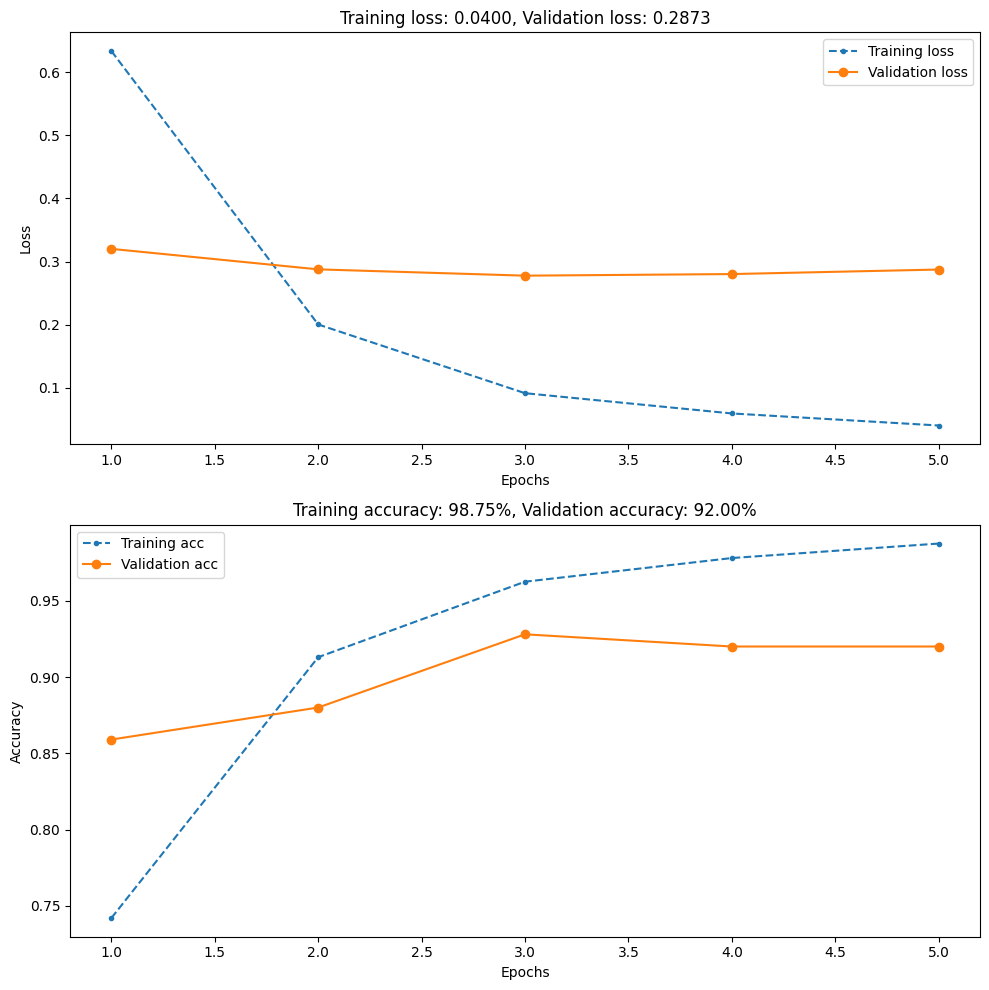

In [9]:
entireModel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = entireModel.fit(train_dataset, epochs=5, validation_data=valid_dataset)
plot_loss_acc(history)

In [10]:
!mkdir -p saved_model
entireModel.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


## LIME

In [12]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [13]:
entireModel = tf.keras.models.load_model('saved_model/my_model')

In [14]:
explainer = lime_image.LimeImageExplainer()

[1.]
1/1 [==============================] - 0s 17ms/step
[1.]


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


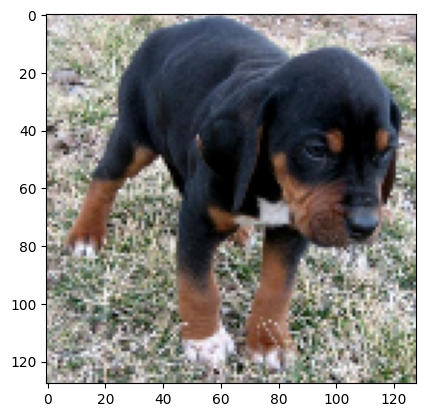

In [25]:
dataset_size = valid_dataset.cardinality().numpy()
rand_idx = np.random.randint(0, 16)

explanation = None
for image, label in valid_dataset.take(1):
    img = image[rand_idx].numpy().astype("uint8")
    plt.imshow(img)
    print (label[rand_idx].numpy())
    out = entireModel.predict(image)
    print(out[rand_idx])
    explanation = explainer.explain_instance(img, entireModel.predict, top_labels=2, hide_color=0, num_samples=100)
#     temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=num_fe, hide_rest=False)
#     plt.imshow(mark_boundaries(temp, mask))

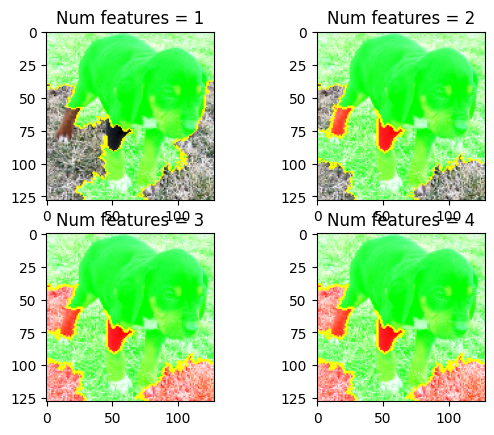

In [26]:
for i in range(1,5):
    num_features = 5*i
#     plt.figure(figsize=(5,5))
    plt.subplot(2,2,i)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=num_features, hide_rest=False)
    plt.title("Num features = "+str())
    plt.imshow(mark_boundaries(temp, mask))


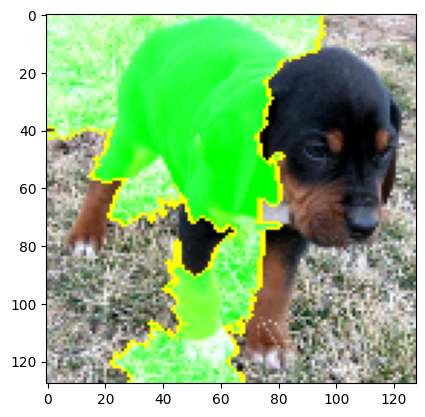

In [30]:
num_features = 3
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=num_features, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))